# Showing MRI from .nii files

In [1]:
import os
import nibabel as nib

In [2]:
base_dir = 'e:/python/images/'

In [3]:
data = nib.load(os.path.join(base_dir, 'anat.nii'))

In [4]:
%matplotlib inline

## Show sample image

(160, 256, 256)


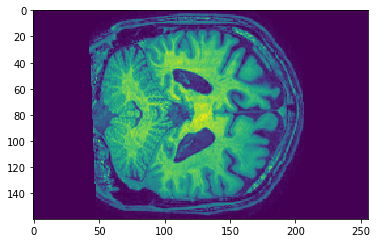

In [5]:
import matplotlib.pyplot as plt
print(data.shape)
plt.imshow(data.get_fdata()[:,90,:])

In [6]:
print(data.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 160 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.          1.          0.99999994  1.          0.          0.
  0.          0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.021473376
quatern_c       : 0.9997622
quatern_d       : -0.00020639141
qoffset_x       : 78.32998
qof

In [7]:
print(data.affine)

[[-9.99048889e-01  4.29381095e-02 -7.59210950e-03  7.83299789e+01]
 [ 4.29349691e-02  9.99077678e-01  5.75942046e-04 -1.23484871e+02]
 [-7.60983722e-03 -2.49427248e-04  9.99971032e-01 -1.07192535e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [8]:
from nilearn.plotting import view_img, glass_brain, plot_anat, plot_epi


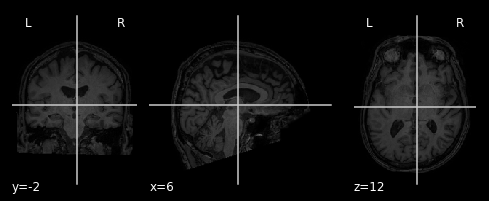

In [9]:
plot_anat(data, display_mode='ortho')

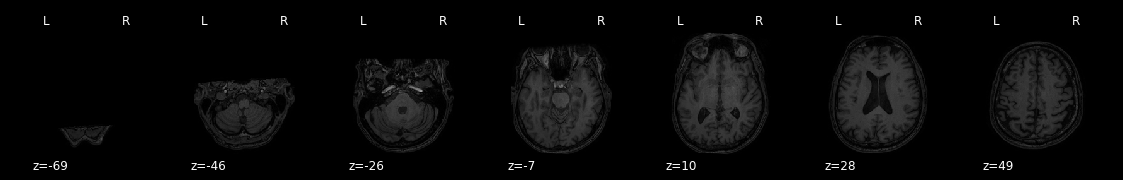

In [10]:
plot_anat(data, draw_cross=False, display_mode='z')

In [11]:
#view_img(data)


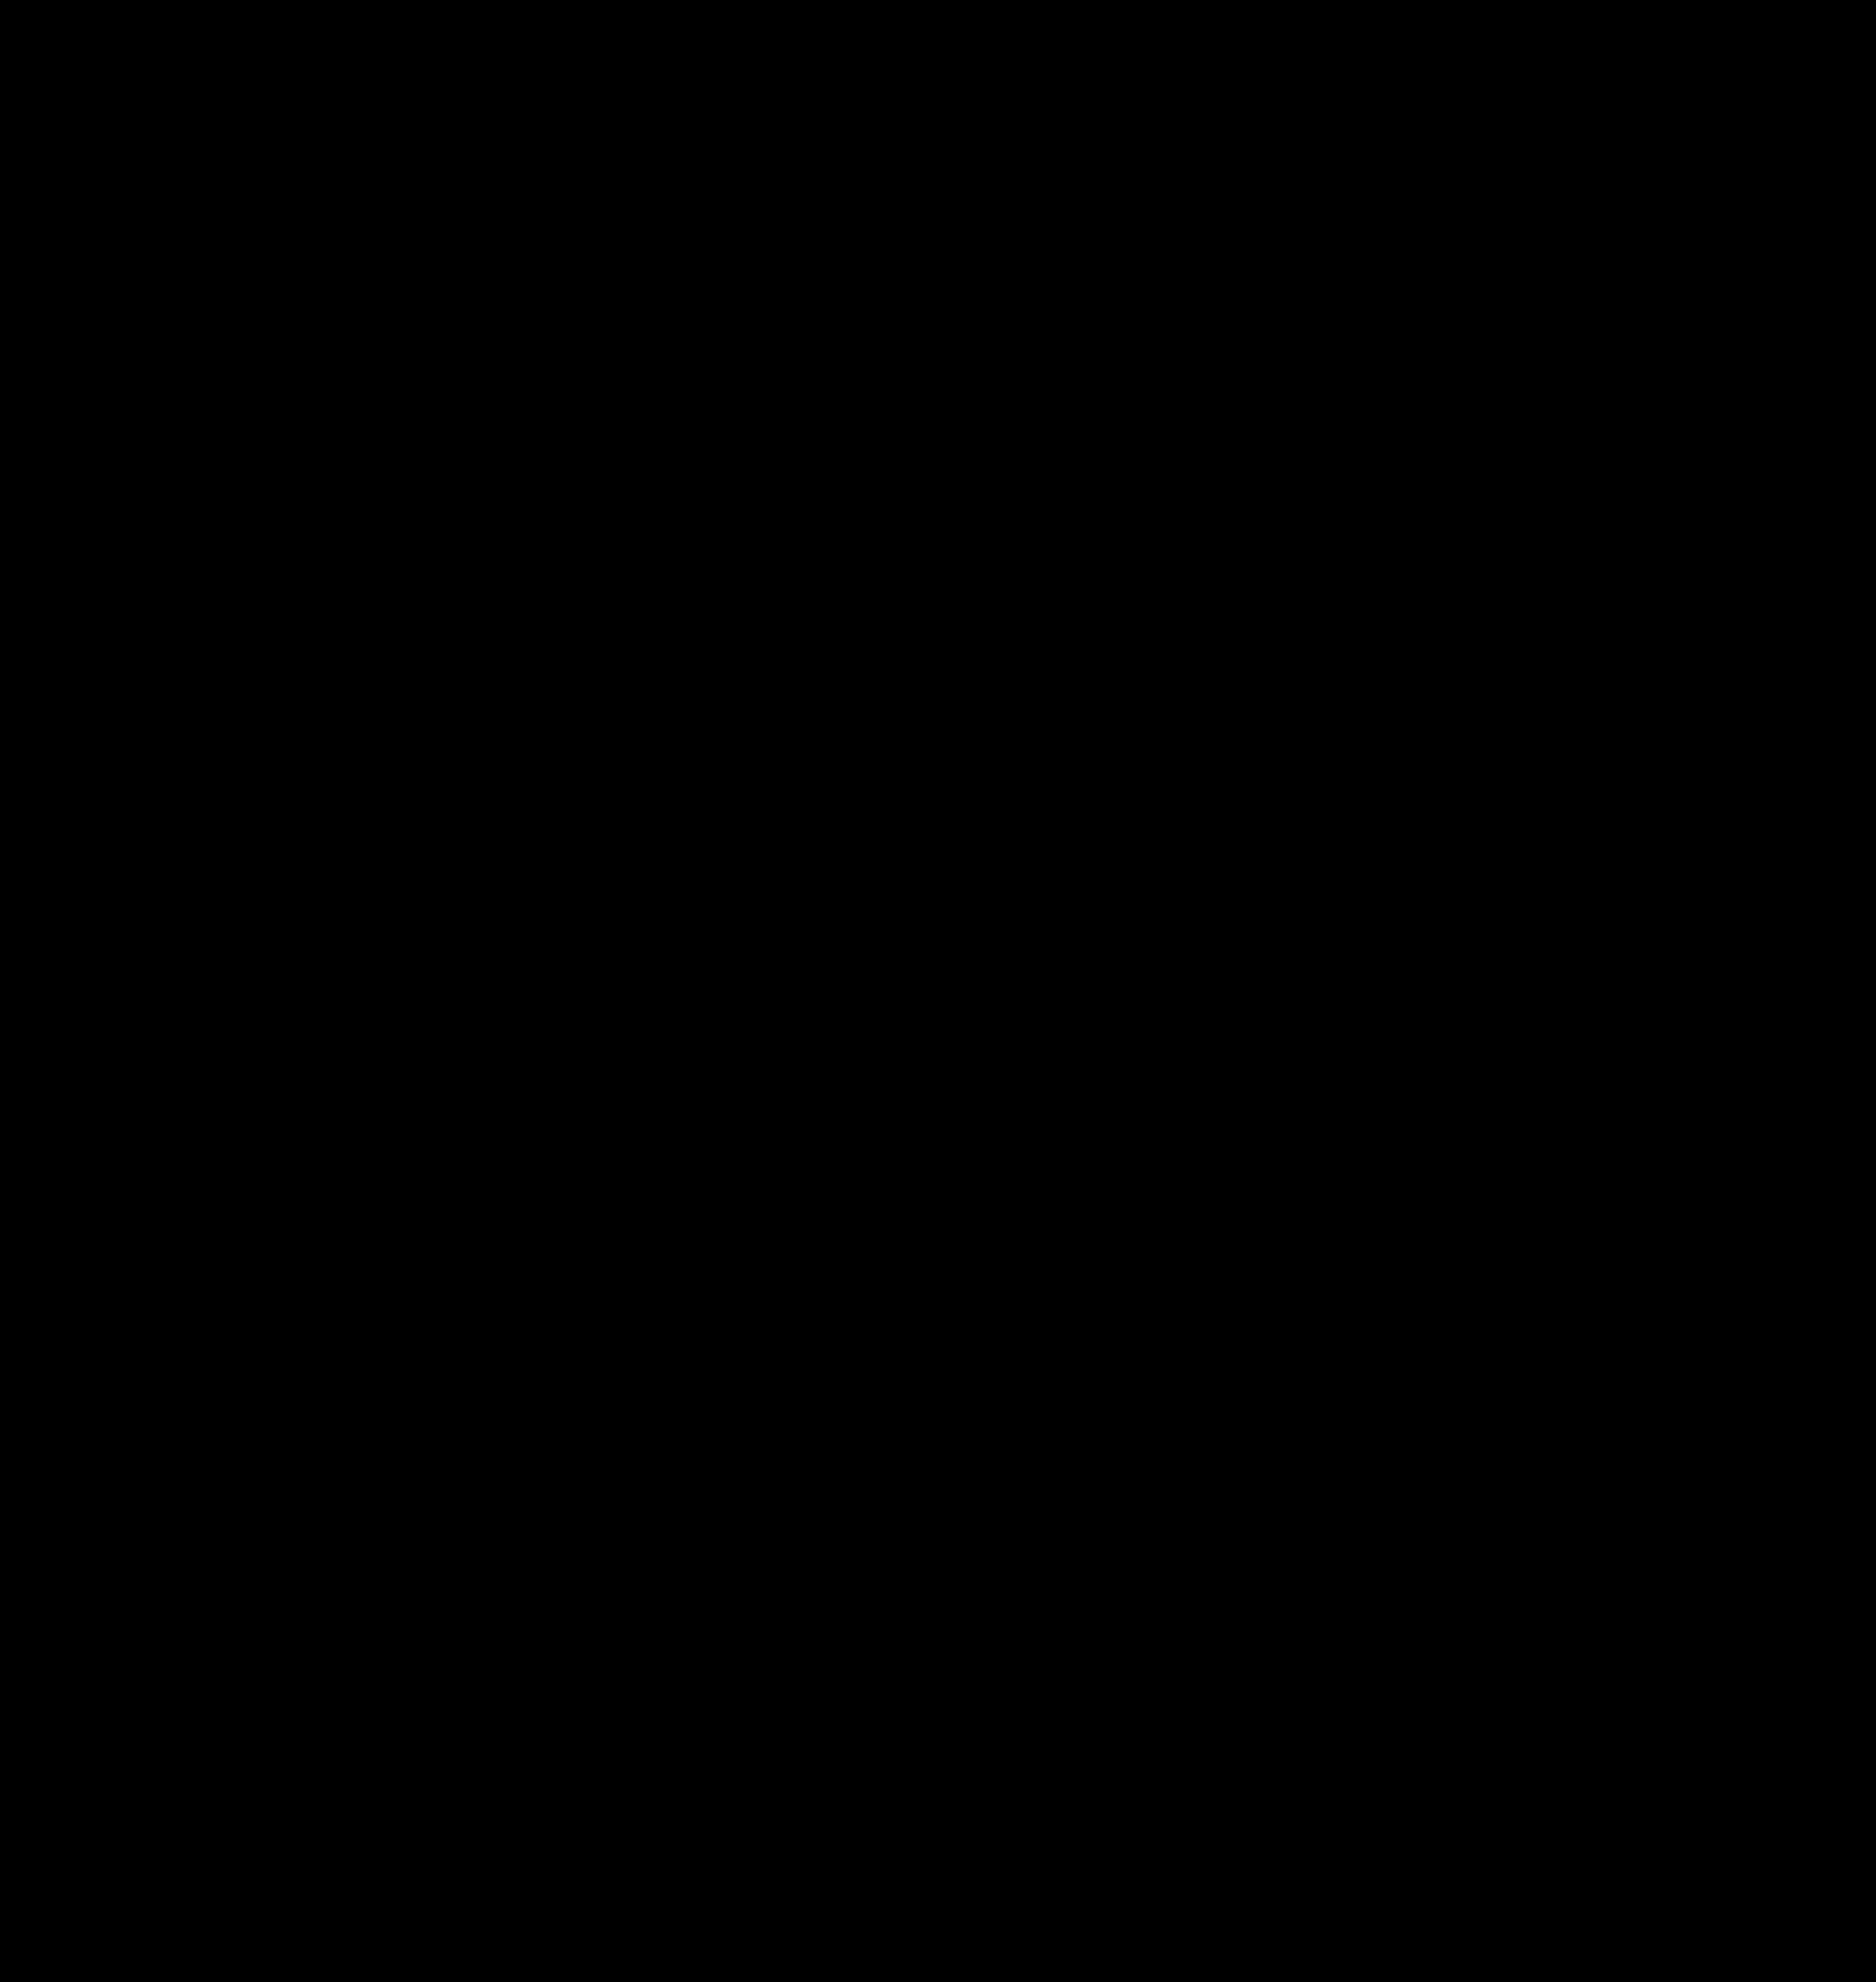
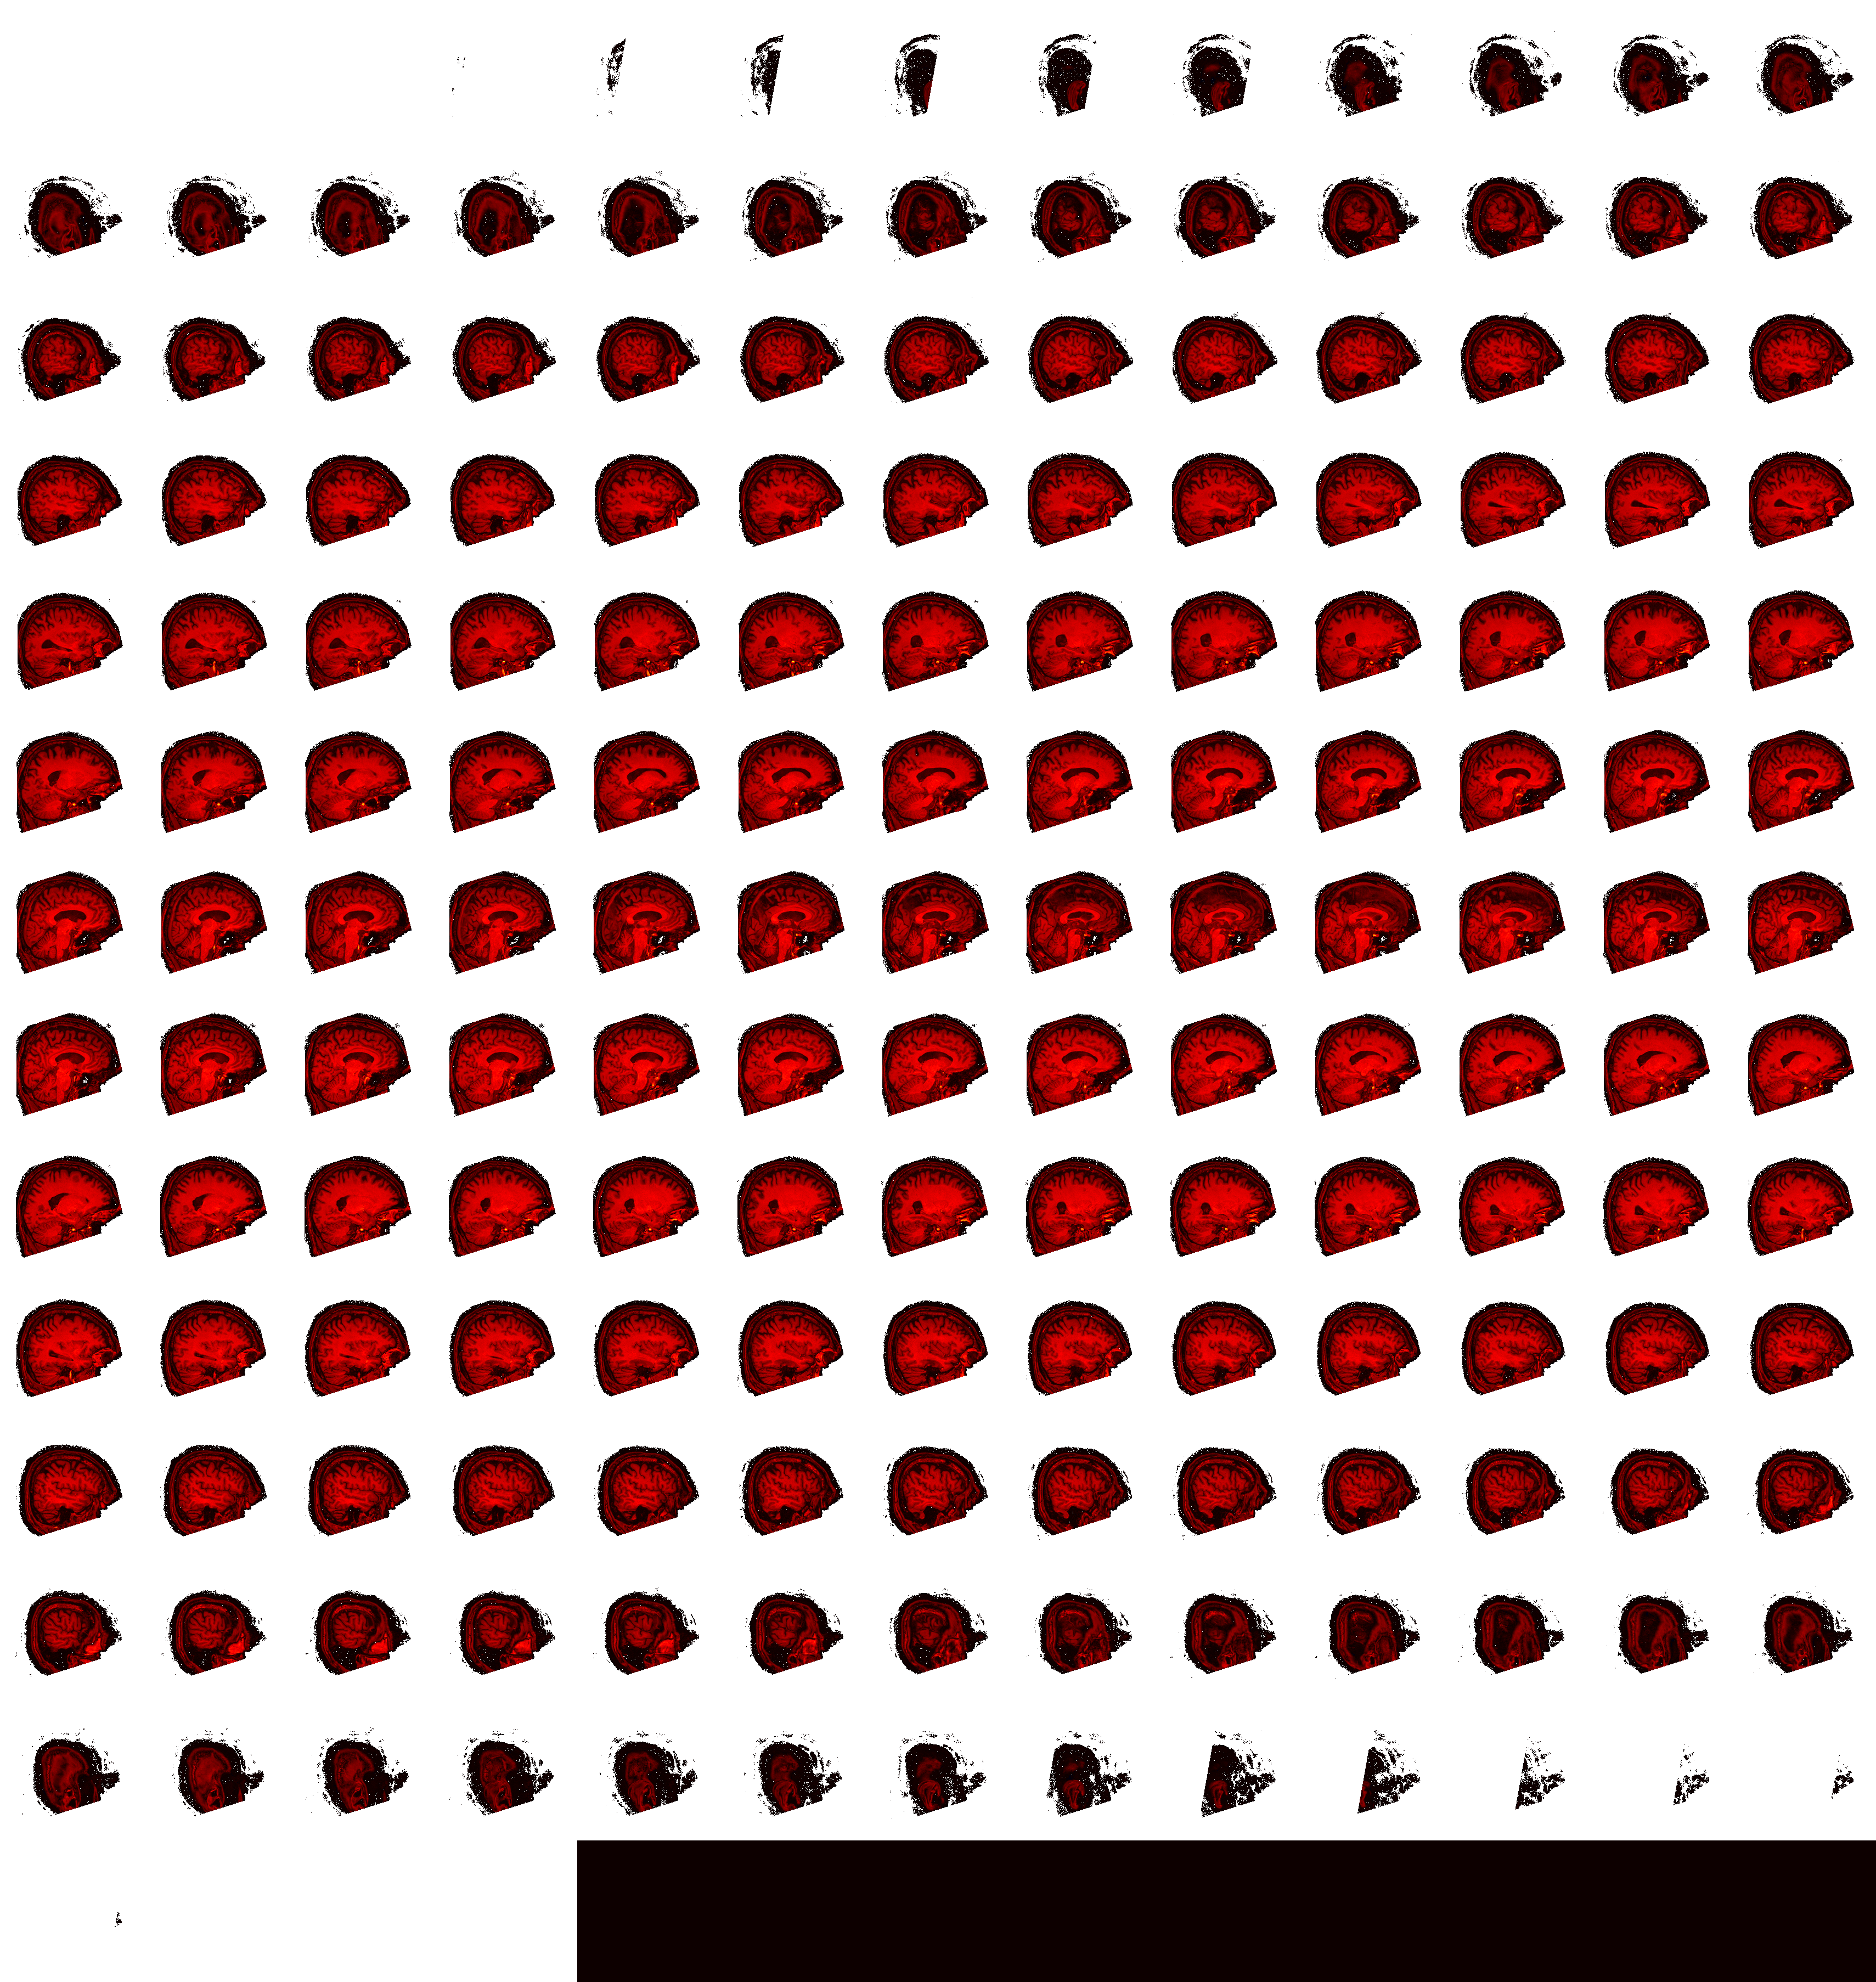

In [12]:
view_img(data, None)

# Showing MRI from .mnc files

In [12]:
base_mnc_dir = 'c:/Users/StarDust/Desktop/tmp/'

In [13]:
mnc_data = nib.load(os.path.join(base_mnc_dir, 'brains_t1', 'brain1_t1.mnc'))

(489, 503, 734)


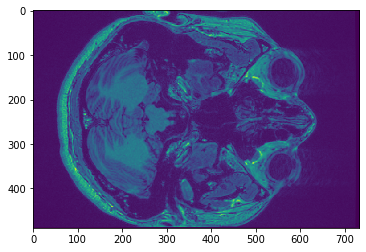

In [14]:
print(mnc_data.shape)
plt.imshow(mnc_data.get_fdata()[:,90,:])

In [15]:
print(mnc_data.header)

In [16]:
print(mnc_data.affine)

[[  0.3     -0.      -0.     -75.4061]
 [  0.      -0.       0.3    -80.3497]
 [  0.       0.3     -0.     -20.8617]
 [  0.       0.       0.       1.    ]]


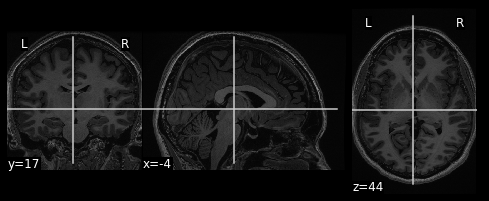

In [17]:
plot_anat(mnc_data)

C:\Users\StarDust\Anaconda3\lib\site-packages\nilearn\plotting\displays.py:1583: UserWarning: A non-diagonal affine is found in the given image. Reordering the image to get diagonal affine for finding cuts in the slices.
  n_cuts=cut_coords)


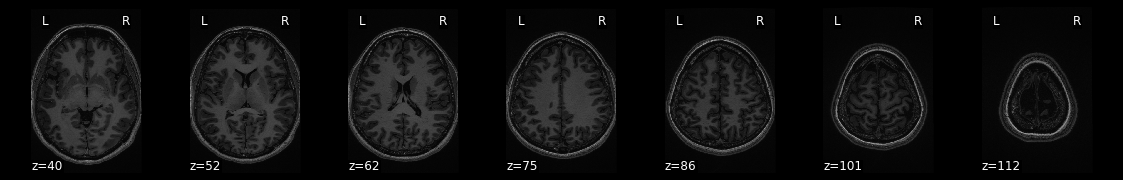

In [17]:
plot_anat(mnc_data, draw_cross=False, display_mode='z')

In [ ]:
view_img(mnc_data, None)

In [15]:
cerebellum_mask = nib.load(os.path.join(base_mnc_dir, 'atlases-master', 'cerebellum', 'labels', 'brain1_labels.mnc'))


In [ ]:
view_img(cerebellum_mask, mnc_data)

In [24]:
view_img(cerebellum_mask, None)

In [25]:
habenula_mask = nib.load(os.path.join(base_mnc_dir, 'atlases-master', 'habenula', 'labels', 'brain1_labels.mnc'))
#view_img(habenula_mask, mnc_data)


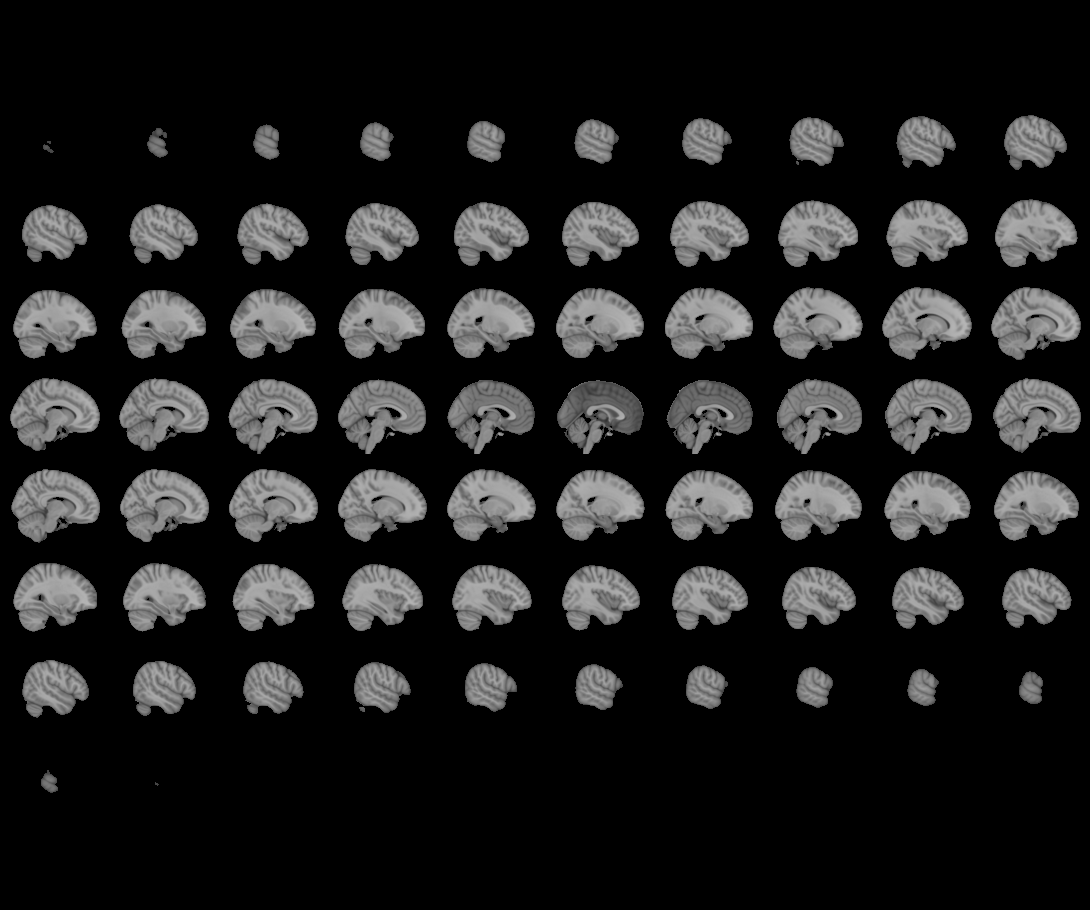
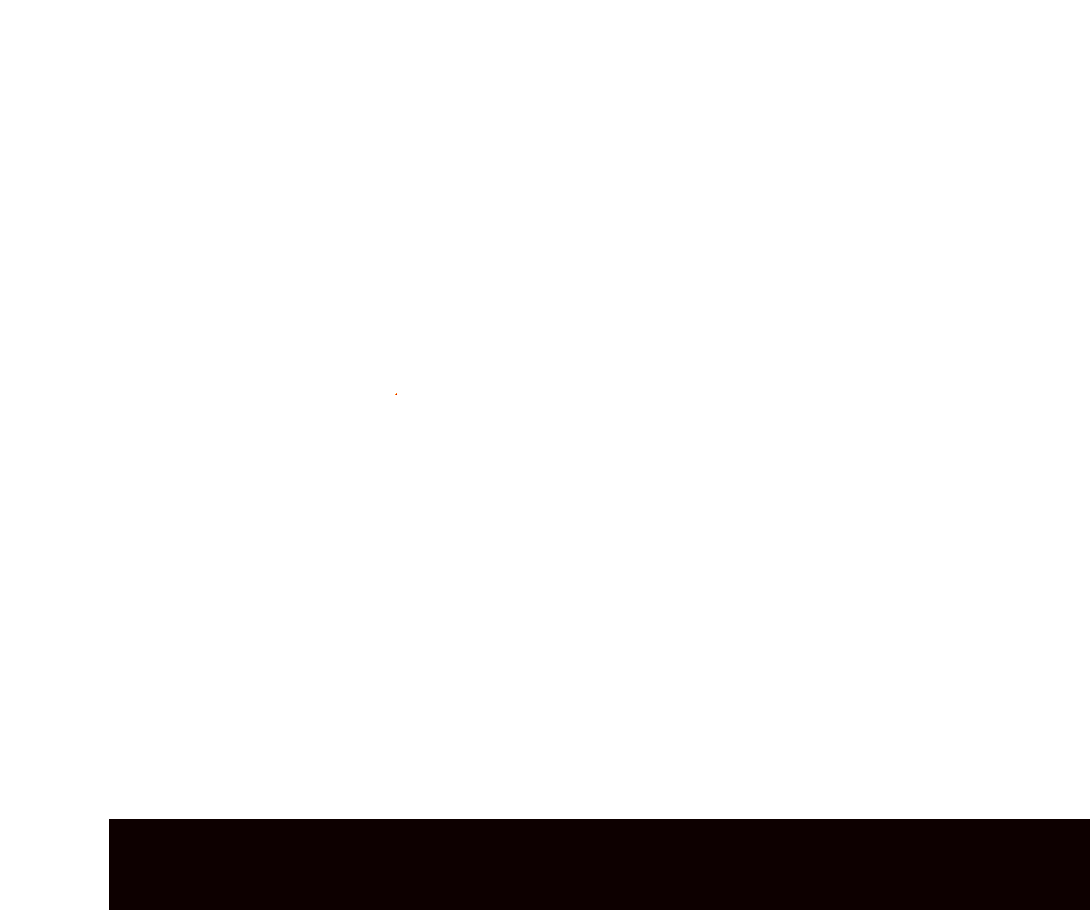

In [63]:
view_img(habenula_mask)

# Showing MRI from sctack of dcm files

In [2]:
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *

In [3]:
data_path = 'e:/python/phd/test_images/dcm/input/'
out_path = 'e:/python/phd/test_images/dcm/output/'
g = glob(data_path + '/*.dcm')
# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print ('\n'.join(g[:5]))

Total of 20 DICOM images.
First 5 filenames:
e:/python/phd/test_images/dcm/input\2.16.840.1.113662.4.10.1.51514854.20140116.7554417.4.dcm
e:/python/phd/test_images/dcm/input\2.16.840.1.113662.4.10.1.51514854.20140116.7554417.5.dcm
e:/python/phd/test_images/dcm/input\2.16.840.1.113662.4.10.1.51514854.20140116.7554417.6.dcm
e:/python/phd/test_images/dcm/input\2.16.840.1.113662.4.10.1.51514854.20140116.7554417.7.dcm
e:/python/phd/test_images/dcm/input\2.16.840.1.113662.4.10.1.51514854.20140116.7554417.8.dcm


In [4]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SlicLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

def get_pixels_hu(scan):
    image = np.stack([s.pixel_array for s in scan])
    image = image.astype(np.int16)
    
    image[image == -2000] = 0
    
    intercept = scan[0].RescaleIntercept if 'RescaleIntercept' in scan[0] else -1024
    slope = scan[0].RescaleSlope if 'RescaleSlope' in scan[0] else 1
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
    
    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)

id = 0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)
    

In [5]:
np.save(out_path + "fullimages_%d.npy" % (id), imgs)

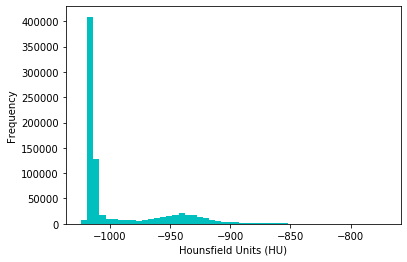

In [6]:
file_used=out_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

IndexError: index 20 is out of bounds for axis 0 with size 20

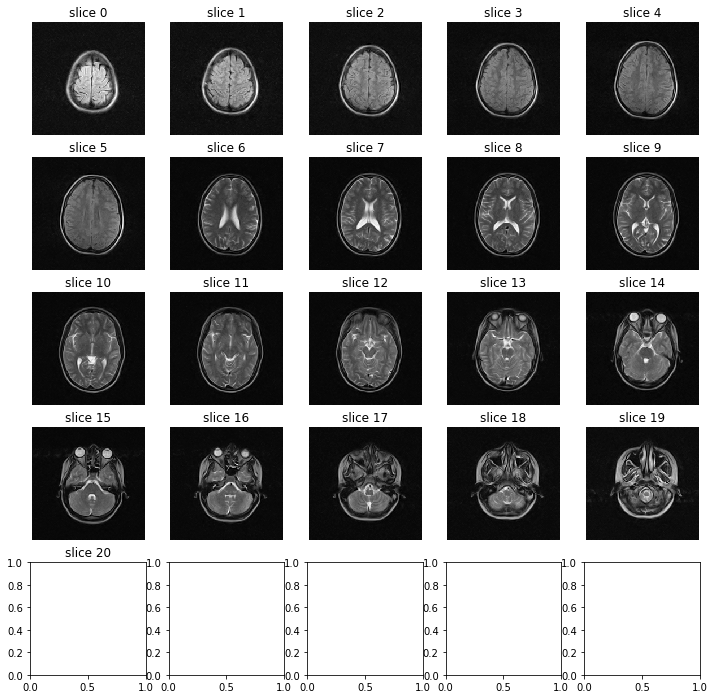

In [7]:
id = 0
imgs_to_process = np.load(out_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=5, cols=5, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

In [9]:
print("Slice Thickness: {0}".format( patient[0].SliceThickness))
print("Pixel Spacing: {0}".format( list([patient[0].SliceThickness]) + list(patient[0].PixelSpacing)))
print("Pixel Spacing (row, col): ({0}, {1}) ".format (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 5.909999999999997
Pixel Spacing: ["5.909999999999997", "1.3", "1.3"]
Pixel Spacing (row, col): (1.300000e+000, 1.300000e+000) 


In [10]:
id = 0
imgs_to_process = np.load(out_path+'fullimages_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (20, 200, 200)
Shape after resampling	 (118, 260, 260)


In [86]:
from ipywidgets.widgets import * 
import ipywidgets as widgets

plt.figure(1, figsize=(10, 10))
def dicom_animation(x):
    plt.imshow(imgs_to_process[x], cmap='gray')
    return x


interact(dicom_animation, x=(0, len(imgs_to_process)-1))

<Figure size 720x720 with 0 Axes>

interactive(children=(IntSlider(value=9, description='x', max=19), Output()), _dom_classes=('widget-interact',…

<function __main__.dicom_animation(x)>

## Convert Dicom files to nifti

In [57]:
import dicom2nifti
import dicom2nifti.settings as settings

#settings.disable_validate_slice_increment()
#settings.enable_resampling()
#settings.set_resample_spline_interpolation_order(1)
#settings.set_resample_padding(-1000)
dicom2nifti.convert_dicom.dicom_array_to_nifti(patient, output_file=out_path + '/output.nii')
dicom2nifti.convert_directory(data_path, out_path)
#view_img(imgs_to_process)

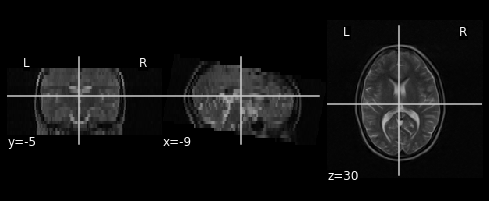

In [66]:
dicom_data = nib.load(out_path + '/output.nii')
view_img(dicom_data, None)
plot_anat(dicom_data)

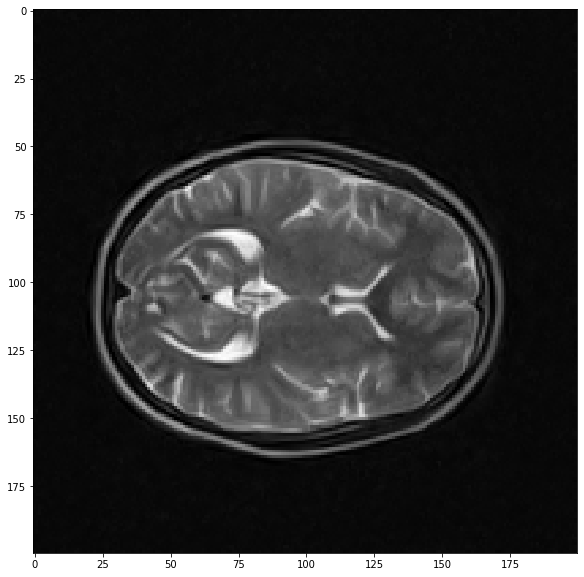

In [85]:
plt.figure(figsize = (10,10))
plt.imshow(dicom_data.get_fdata()[:,:,10],  cmap='gray', aspect='equal', resample=False)

In [39]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
   
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True, use_classic=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print ("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(0, 0, 0)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    #ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    plt.show()

In [13]:
#level = 0.5 * (imgs_after_resamp.min() + imgs_after_resamp.max())
#v, f = make_mesh(imgs_to_process, -1000)
#plt_3d(v, f)


In [14]:
#plotly_3d(v, f)